# LAB 04 – Image Processing
## Topics: Image Flipping · Intensity Transformation · Bit-Plane Slicing

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Load the image once – reused across all tasks
IMG_PATH = "team2.jpg"

img_bgr  = cv2.imread(IMG_PATH)
img_gray = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)

if img_bgr is None:
    raise FileNotFoundError(f"Cannot find {IMG_PATH}. Make sure it is in the same folder as this notebook.")

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
print(f"Image loaded: {img_bgr.shape}  dtype={img_bgr.dtype}")

Image loaded: (800, 800, 3)  dtype=uint8


---
## Section 1 – Image Flipping

### Task 1 – Convert color image to grayscale

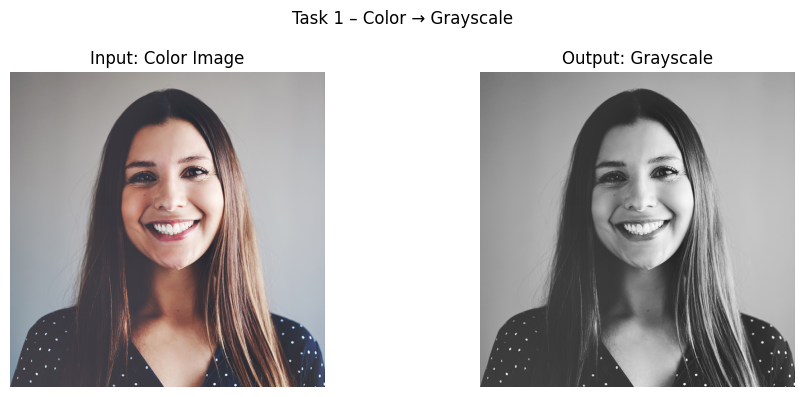

In [12]:
def color_to_grayscale(img_bgr):
    """Takes a color BGR image and returns its grayscale version."""
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

gray = color_to_grayscale(img_bgr)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(img_rgb);          axes[0].set_title("Input: Color Image"); axes[0].axis('off')
axes[1].imshow(gray, cmap='gray'); axes[1].set_title("Output: Grayscale");  axes[1].axis('off')
plt.suptitle("Task 1 – Color → Grayscale")
plt.tight_layout()
plt.show()

### Task 2 – Mirror Effect
Concatenate the original with its horizontally flipped copy — equivalent to Matlab's `C = [A B]`.

(np.float64(-0.5), np.float64(799.5), np.float64(799.5), np.float64(-0.5))

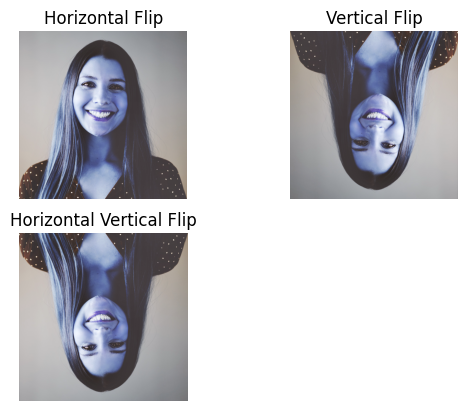

In [14]:
hflip = cv2.flip(img_bgr, 1)

vflip = cv2.flip(img_bgr, 0)

hvflip = cv2.flip(img_bgr, -1)

plt.subplot(2,2,1)
plt.imshow(hflip)
plt.title("Horizontal Flip")
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(vflip)
plt.title("Vertical Flip")
plt.axis("off")

plt.subplot(2,2,3)
plt.imshow(hvflip)
plt.title("Horizontal Vertical Flip")
plt.axis("off")

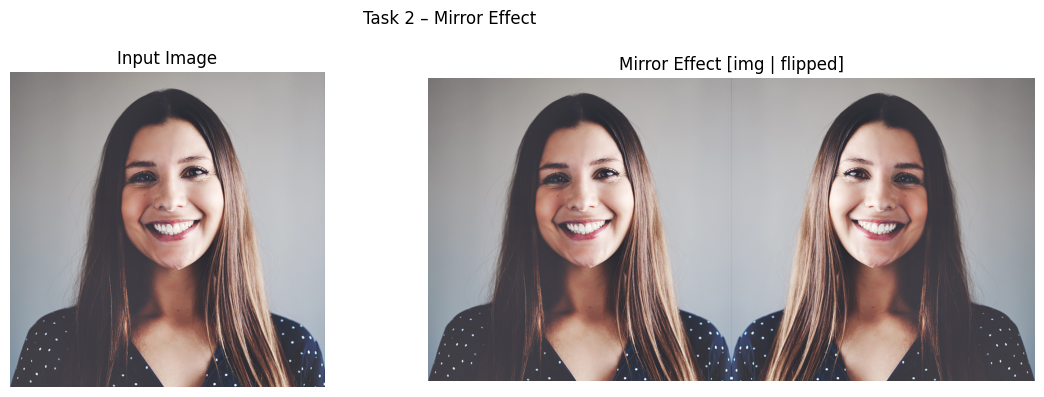

In [13]:
def mirror_effect(img_bgr):
    """Returns [original | horizontally flipped] side by side."""
    flipped = cv2.flip(img_bgr, 1)            # 1 = flip along vertical axis
    return np.concatenate([img_bgr, flipped], axis=1)   # [A B] in Matlab terms

mirrored_bgr = mirror_effect(img_bgr)
mirrored_rgb = cv2.cvtColor(mirrored_bgr, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(img_rgb);      axes[0].set_title("Input Image");                  axes[0].axis('off')
axes[1].imshow(mirrored_rgb); axes[1].set_title("Mirror Effect [img | flipped]"); axes[1].axis('off')
plt.suptitle("Task 2 – Mirror Effect")
plt.tight_layout()
plt.show()

---
## Section 2 – Intensity Transformation

### Task 1 – Image Negative
Formula: **s = L − 1 − r** = 255 − r

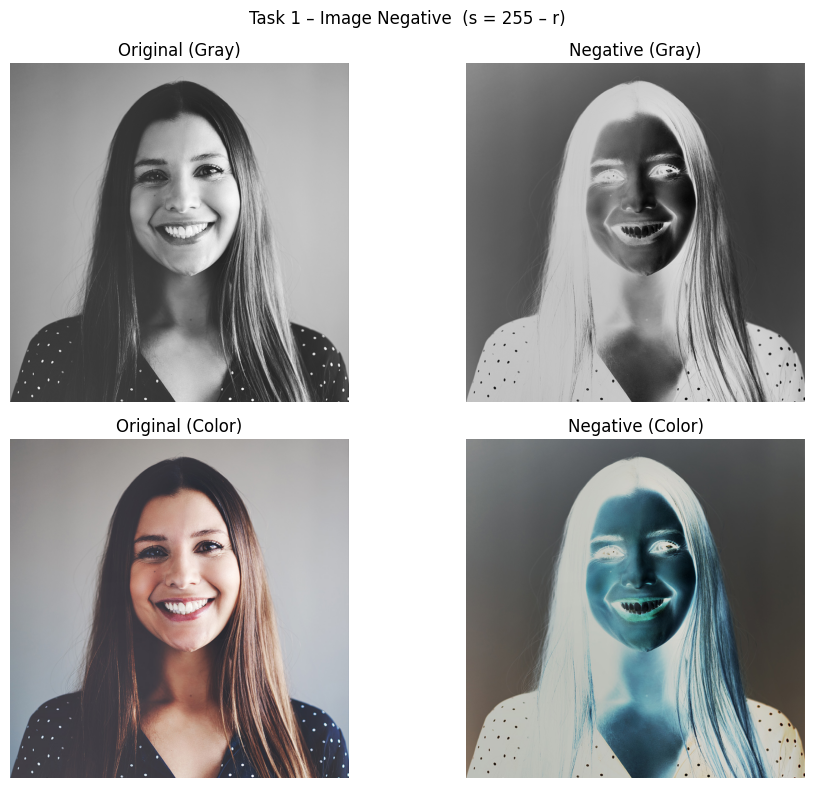

In [15]:
def image_negative(img):
    """s = 255 - r  (works for both grayscale and color uint8 images)"""
    return 255 - img

neg_gray  = image_negative(img_gray)
neg_color = image_negative(img_bgr)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes[0, 0].imshow(img_gray,                    cmap='gray'); axes[0, 0].set_title("Original (Gray)");    axes[0, 0].axis('off')
axes[0, 1].imshow(neg_gray,                    cmap='gray'); axes[0, 1].set_title("Negative (Gray)");    axes[0, 1].axis('off')
axes[1, 0].imshow(img_rgb);                                  axes[1, 0].set_title("Original (Color)");   axes[1, 0].axis('off')
axes[1, 1].imshow(cv2.cvtColor(neg_color, cv2.COLOR_BGR2RGB)); axes[1, 1].set_title("Negative (Color)"); axes[1, 1].axis('off')
plt.suptitle("Task 1 – Image Negative  (s = 255 – r)")
plt.tight_layout()
plt.show()

### Task 2 – Power-law (Gamma) Curves: s = c · r^γ

**(a) Non-normalized** — r ∈ [0, 255]  
**(b) Normalized** — r ∈ [0, 1]

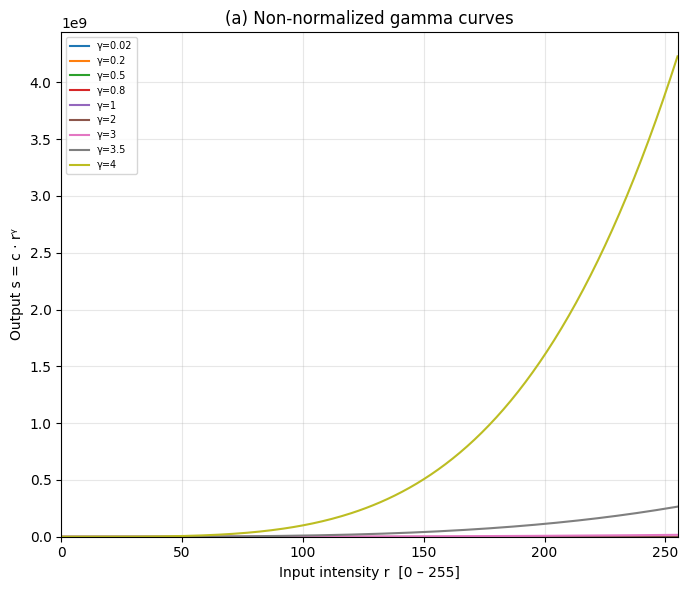

WHY curves don't meet at y=255:
  s(255) = 1 × 255^γ  →  equals 255 ONLY when γ=1.
  γ < 1 : 255^γ < 255  |  γ > 1 : 255^γ > 255 (clips to 255 in uint8 images)


In [16]:
gammas = [0.02, 0.2, 0.5, 0.8, 1, 2, 3, 3.5, 4]
c = 1

# ── (a) Non-normalized ────────────────────────────────────────────────────────
x_raw = np.arange(0, 256, dtype=np.float32)

fig, ax = plt.subplots(figsize=(7, 6))
for g in gammas:
    ax.plot(x_raw, c * (x_raw ** g), label=f"γ={g}")
ax.set_xlabel("Input intensity r  [0 – 255]")
ax.set_ylabel("Output s = c · rᵞ")
ax.set_title("(a) Non-normalized gamma curves")
ax.legend(fontsize=7, loc='upper left')
ax.set_xlim(0, 255); ax.set_ylim(bottom=0)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("WHY curves don't meet at y=255:")
print("  s(255) = 1 × 255^γ  →  equals 255 ONLY when γ=1.")
print("  γ < 1 : 255^γ < 255  |  γ > 1 : 255^γ > 255 (clips to 255 in uint8 images)")

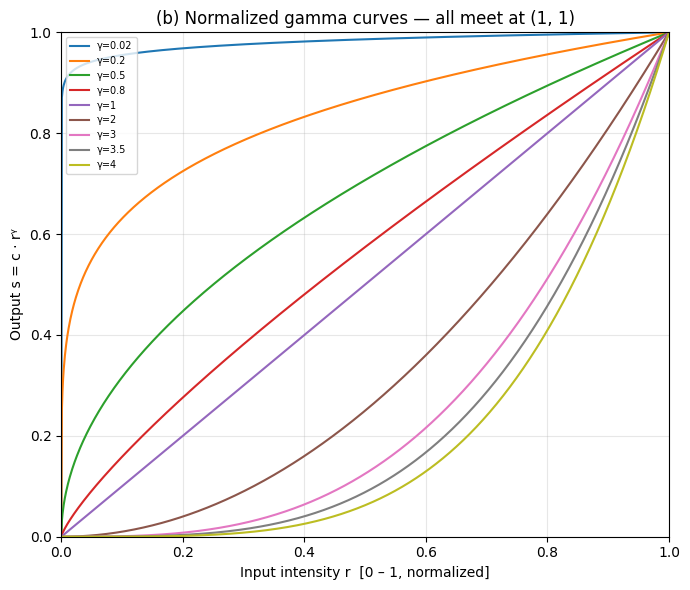

WHY normalized curves all meet at (1, 1):
  s(1) = c × 1^γ = 1 × 1 = 1  for ANY value of γ.
  Normalizing maps both domain and range to [0,1], forcing every curve through (0,0) and (1,1).


In [17]:
# ── (b) Normalized ───────────────────────────────────────────────────────────
x_norm = np.arange(0, 1.001, 0.001, dtype=np.float32)

fig, ax = plt.subplots(figsize=(7, 6))
for g in gammas:
    ax.plot(x_norm, c * (x_norm ** g), label=f"γ={g}")
ax.set_xlabel("Input intensity r  [0 – 1, normalized]")
ax.set_ylabel("Output s = c · rᵞ")
ax.set_title("(b) Normalized gamma curves — all meet at (1, 1)")
ax.legend(fontsize=7, loc='upper left')
ax.set_xlim(0, 1); ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("WHY normalized curves all meet at (1, 1):")
print("  s(1) = c × 1^γ = 1 × 1 = 1  for ANY value of γ.")
print("  Normalizing maps both domain and range to [0,1], forcing every curve through (0,0) and (1,1).")

### Task 3 – Gamma Correction applied to the image

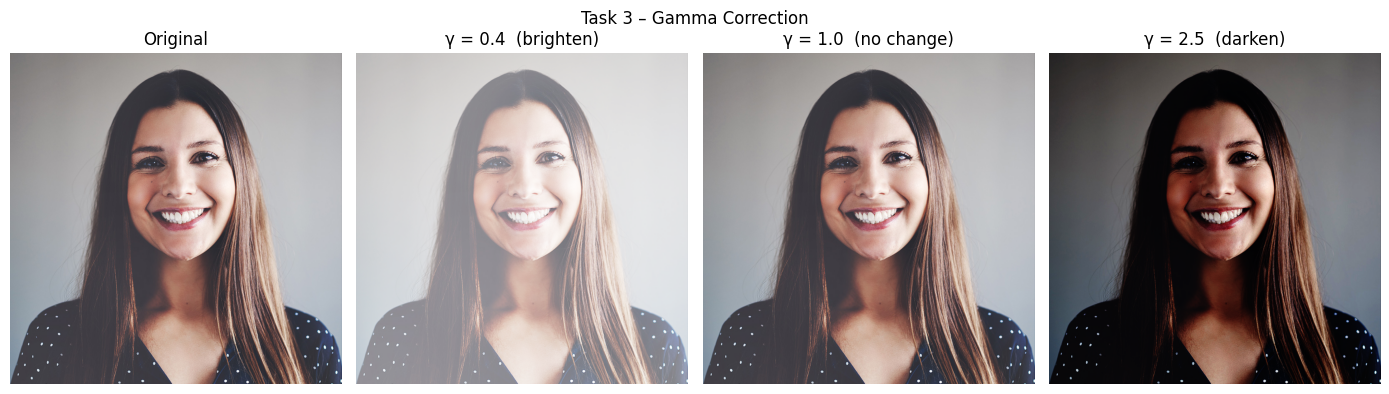

In [18]:
def gamma_correction(img, gamma, c=1):
    """Apply s = c * (r/255)^gamma, scale result back to [0,255]."""
    norm      = img.astype(np.float32) / 255.0
    corrected = np.clip(c * (norm ** gamma), 0, 1)
    return (corrected * 255).astype(np.uint8)

demo_gammas = [0.4, 1.0, 2.5]   # γ<1 brightens, γ=1 identity, γ>1 darkens

fig, axes = plt.subplots(1, len(demo_gammas) + 1, figsize=(14, 4))
axes[0].imshow(img_rgb); axes[0].set_title("Original"); axes[0].axis('off')

for i, g in enumerate(demo_gammas):
    out = gamma_correction(img_bgr, g)
    axes[i + 1].imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
    axes[i + 1].set_title(f"γ = {g}  ({'brighten' if g < 1 else 'darken' if g > 1 else 'no change'})")
    axes[i + 1].axis('off')

plt.suptitle("Task 3 – Gamma Correction")
plt.tight_layout()
plt.show()

### Task 4 – Highlight intensity range [A, B] → L−1 = 255

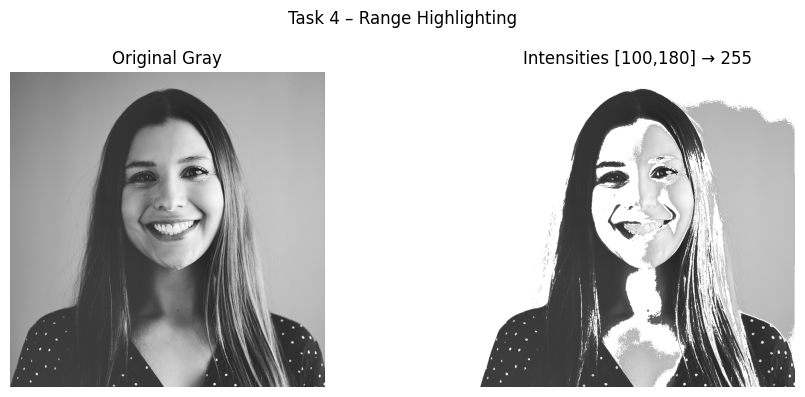

In [19]:
def highlight_range(img_gray, A, B):
    """
    Returns a copy where every pixel with intensity in [A, B] is set to L-1 = 255.
    Uses boolean indexing (equivalent to Matlab's find function).
    """
    out  = img_gray.copy()
    mask = (img_gray >= A) & (img_gray <= B)   # find() equivalent
    out[mask] = 255
    return out

A, B = 100, 180   # adjust as needed
highlighted = highlight_range(img_gray, A, B)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(img_gray,    cmap='gray'); axes[0].set_title("Original Gray");               axes[0].axis('off')
axes[1].imshow(highlighted, cmap='gray'); axes[1].set_title(f"Intensities [{A},{B}] → 255"); axes[1].axis('off')
plt.suptitle("Task 4 – Range Highlighting")
plt.tight_layout()
plt.show()

### Task 5 – Appropriate enhancement based on histogram analysis

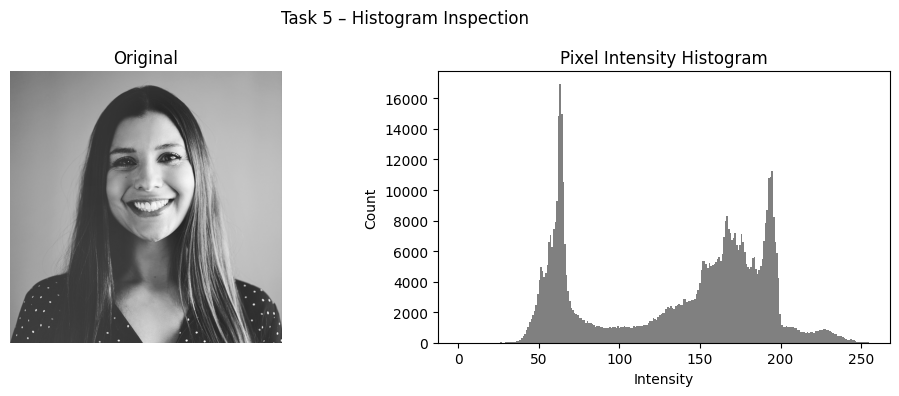

Mean brightness: 136.1  →  chosen γ = 1.0


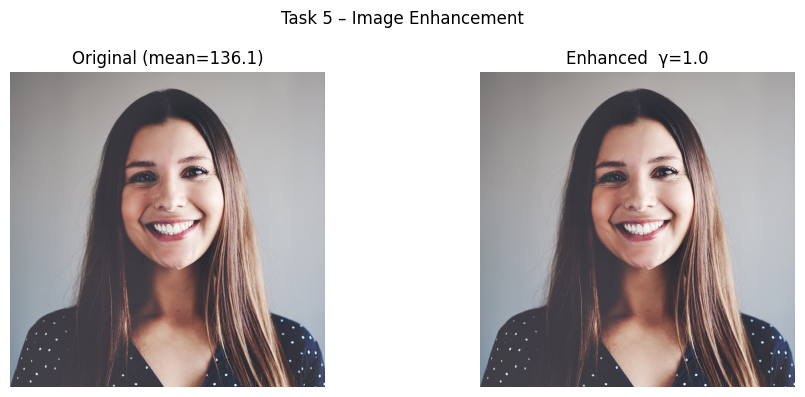

In [20]:
# Inspect histogram first
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(img_gray, cmap='gray'); axes[0].set_title("Original"); axes[0].axis('off')
axes[1].hist(img_gray.ravel(), bins=256, range=(0, 255), color='gray')
axes[1].set_title("Pixel Intensity Histogram")
axes[1].set_xlabel("Intensity"); axes[1].set_ylabel("Count")
plt.suptitle("Task 5 – Histogram Inspection")
plt.tight_layout()
plt.show()

# Auto-pick gamma based on mean brightness
mean_val = img_gray.mean()
chosen_gamma = 0.5 if mean_val < 100 else (2.0 if mean_val > 170 else 1.0)
print(f"Mean brightness: {mean_val:.1f}  →  chosen γ = {chosen_gamma}")

enhanced = gamma_correction(img_bgr, chosen_gamma)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(img_rgb);                                          axes[0].set_title(f"Original (mean={mean_val:.1f})"); axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB));        axes[1].set_title(f"Enhanced  γ={chosen_gamma}");      axes[1].axis('off')
plt.suptitle("Task 5 – Image Enhancement")
plt.tight_layout()
plt.show()

---
## Section 3 – Bit-Plane Slicing

### Task 1 – `displayBitResponse`: show all 8 bit planes

Each uint8 pixel has 8 bits: **b₇ b₆ b₅ b₄ b₃ b₂ b₁ b₀**  
- **Plane 1** = LSB (b₀) → mostly noise, low structural info  
- **Plane 8** = MSB (b₇) → dominant, carries main structural content

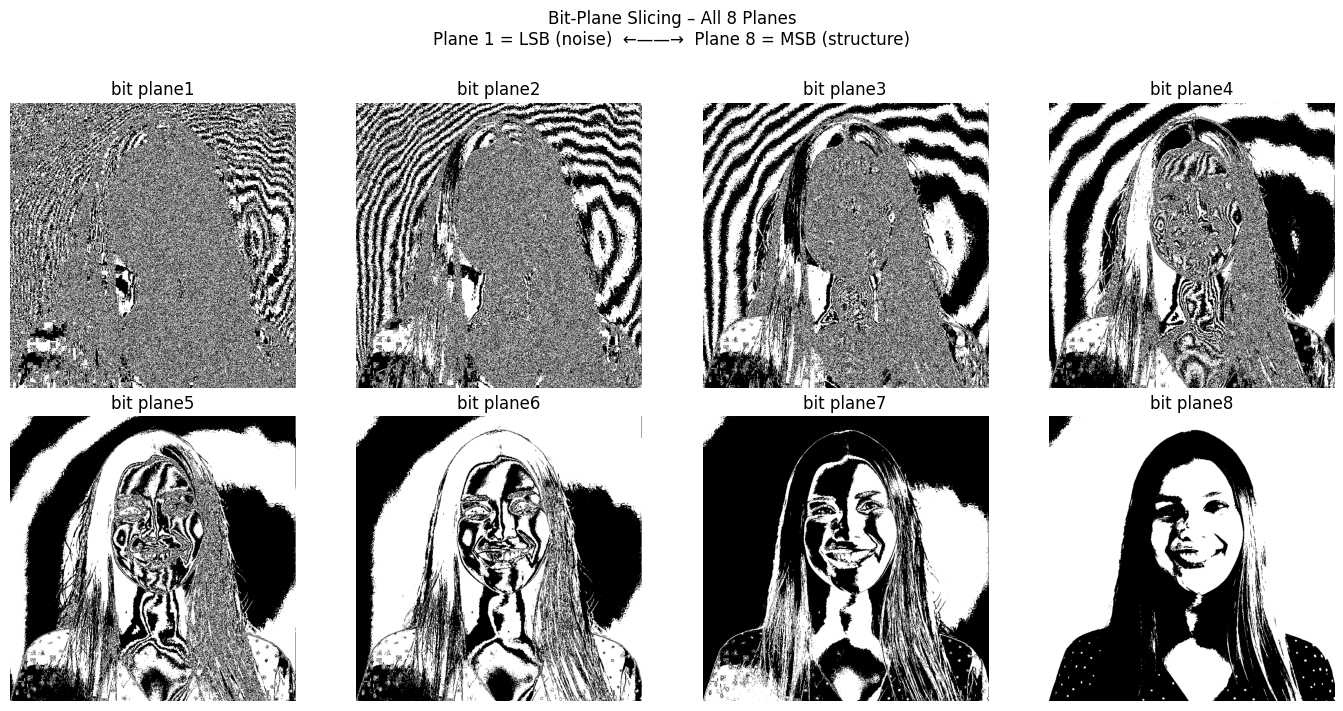

In [21]:
def displayBitResponse(img):
    """
    Takes a grayscale (or color) image and displays all 8 bit-plane images.
    Bit plane k: extract the k-th bit  →  (img >> (k-1)) & 1
    Multiply by 255 to make the binary image visible (0 or 255).
    """
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    fig, axes = plt.subplots(2, 4, figsize=(14, 7))
    axes = axes.flatten()

    for k in range(1, 9):                           # k = 1 (LSB) … 8 (MSB)
        plane = ((img >> (k - 1)) & 1).astype(np.uint8) * 255
        axes[k - 1].imshow(plane, cmap='gray')
        axes[k - 1].set_title(f"bit plane{k}")
        axes[k - 1].axis('off')

    plt.suptitle(
        "Bit-Plane Slicing – All 8 Planes\n"
        "Plane 1 = LSB (noise)  ←——→  Plane 8 = MSB (structure)",
        y=1.01
    )
    plt.tight_layout()
    plt.show()

displayBitResponse(img_gray)